In [7]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import os

In [8]:
class Job:
    def __init__(self, Ta, Ts, index, delayHistLength):
        length = np.size(Ta)
        Td = np.zeros(length)
        Tw = np.zeros(length)
        Ba = np.zeros(length)
        MA = np.zeros(length)
        if delayHistLength == 0:
            self.dict = dict(zip(index, list(map(list, list(zip(Ta, Td, Ts, Tw, Ba, MA))))))
        else:
            delayHistory = np.zeros((np.shape(Ta)[0], delayHistLength))
            delayHistory_Ta = np.zeros((np.shape(Ta)[0], delayHistLength))
            self.dict = dict(zip(index, np.hstack((list(map(list, list(zip(Ta, Td, Ts, Tw, Ba, MA)))), delayHistory_Ta, delayHistory))))
        # Dictionary values:  1-ArrivalTime 2-DepartureTime 3-ServiceTime 4-WaitingTime 5-BackloggUponArrival 6-ServiceTimeMovingAverage
        # 7-...-ServiceTimes of (serviceHistLength) previous jobs [optional] 8-...-Delays of (delayHistLength) previous jobs [optional]


def infQueueMultiServ_CHANjob(job, MAlength, N0, delayHistLength, QLnoise="False",
                              QLnoise_sigma=0):
    jobMatrix = np.array(list(job.dict.values()))
    jobIndex = np.array(list(job.dict.keys()))
    length = len(jobIndex)
    order = np.argsort(jobMatrix[:, 0])
    Ta = jobMatrix[:, 0][order]
    Ts = jobMatrix[:, 2][order]
    jobIndexOrdered = jobIndex[order]
    indexout = []
    f = Ta[0:N0] + Ts[0:N0]
    les_f = Ta[0:N0]
    d = sorted(f)
    e = sorted(les_f)
    index = jobIndexOrdered[np.argsort(f)]
    backlogD = [[0, 0, 0]]
    backlogA = []
    jobDepCum = []
    jobEsCum = []

    for i in tqdm(range(0, length)):
        JobDep, d = d[0], np.delete(d, 0)
        Es, e = e[0], np.delete(e, 0)
        indexout = np.append(indexout, index[0])
        index = np.delete(index, 0)

        jobDepCum.append(JobDep)
        jobEsCum.append(Es)

        tempOcc = float(np.sum(Ta <= JobDep) - (i + 1))
        backlogD.append([JobDep, max(tempOcc - N0, 0.0), tempOcc])
        tempOcc = float(i + 1 - np.sum(jobDepCum <= Ta[i]))
        backlogA.append([Ta[i], max(tempOcc - N0, 0.0), tempOcc])
        job.dict[jobIndex[i]][4] = np.round(max(i - np.sum(jobDepCum <= Ta[i]), 0))
        # num of customors in the system (including servers) right upon i'th arrival

        if i <= length - N0 - 1:
            F = max(Ta[N0 + i], JobDep) + Ts[N0 + i]
            u = np.append(F, d)
            u = np.maximum(u, F)
            addedIndex = np.sum(u == F) - 1
            d = np.minimum(np.append(d, np.inf), u)
            index = np.append(index[:addedIndex], np.append(jobIndexOrdered[N0 + i], index[addedIndex:]))
            # \\\\\\\\\\\\\\\\\\\\\\\
            e = np.append(e, max(Ta[N0 + i], JobDep))

        job.dict[indexout[-1]][1] = JobDep
        # job.dict[indexout[-1]][3]= max(0 , JobDep - job.dict[indexout[-1]][0]) # delay (Sojourn)
        job.dict[indexout[-1]][3] = max(0.0, JobDep - job.dict[indexout[-1]][0] - job.dict[indexout[-1]][2])  # waiting

    jobEsCum = np.array(jobEsCum)
    # print(np.shape(jobEsCum))

    for i in range(delayHistLength, length):
        indexx = np.arange(1, i + 2)
        temp = indexx[jobEsCum[:i + 1] < Ta[i]]
        # print(temp)
        if len(temp) > delayHistLength-1:  # Delay history
            job.dict[jobIndex[i]][-delayHistLength:] = [job.dict[j][3] for j in
                                                    temp[-delayHistLength:]]
            job.dict[jobIndex[i]][-2*delayHistLength: -delayHistLength] = [job.dict[j][0] for j in
                                                    temp[-delayHistLength:]]

    backlogA = np.concatenate((backlogA, backlogD))
    backlogA = np.array(sorted(backlogA, key=lambda x: x[0]))
    job.b = backlogA
    job.index = indexout.astype(int)


# Defining different arrival and service processes

In [9]:
def MarkovOnOff(length, Alpha, Beta, Lambda):  # Alpha = off-> on | Beta = on -> off
    s = 1
    interArr = np.zeros(length)
    i = 0
    while i < length:

        state_stay = np.random.exponential(1 / Beta)
        elapsed_time = 0
        while s and i < length:
            temp = np.random.exponential(1/Lambda)
            elapsed_time = elapsed_time + temp
            if elapsed_time < state_stay:
                interArr[i] = interArr[i] + temp
                i += 1
            else:
                interArr[i] = interArr[i] + state_stay - (elapsed_time - temp)
                s = 0
        if not s and i < length:
            state_stay = np.random.exponential(1 / Alpha)
            interArr[i] = interArr[i] + state_stay
            s = 1
    Ta = np.cumsum(interArr)
    return Ta


def DetOnOff(length, Ton, Toff, Ta_ON):
    Num_ON = int(Ton/Ta_ON)
    Num_OFF = int(Toff/Ta_ON)
    inter_arr = []
    i = 0
    while i < length-Num_ON:
            inter_arr = np.append(inter_arr, Ta_ON * np.ones(Num_ON-1))
            # inter_arr = np.append(inter_arr, np.random.exponential(Ta_ON, Num_ON-1))
            inter_arr = np.append(inter_arr, Ta_ON * Num_OFF)
            i += Num_ON
    inter_arr = np.append(inter_arr, Ta_ON * np.ones(length-i))
    Ta = np.cumsum(inter_arr)
    return Ta

def DetVarRate(length, t_on1, t_on2, t_a1, t_a2):
    Num_ON1 = int(t_on1/t_a1)
    Num_ON2 = int(t_on2/t_a2)
    inter_arr = []
    i = 0
    while i < length-Num_ON1-Num_ON2:
            inter_arr = np.append(inter_arr, t_a1 * np.ones(Num_ON1))
            inter_arr = np.append(inter_arr, t_a2 * np.ones(Num_ON2))
            i += Num_ON1+Num_ON2
    if length-i > Num_ON1:
        inter_arr = np.append(inter_arr, t_a1 * np.ones(Num_ON1))
        inter_arr = np.append(inter_arr, t_a2 * np.ones(length-i-Num_ON1))
    else:
        inter_arr = np.append(inter_arr, t_a1 * np.ones(length - i))
    Ta = np.cumsum(inter_arr)
    return Ta


def NonHomPoisson(length, Lambda, lambda_u):
    Ta = []
    t = 0
    l = 0
    while l < length:
        t = t + np.random.exponential(1/lambda_u)
        if np.random.uniform(0, 1) < Lambda(t)/lambda_u:
            Ta.append(t)
            l += 1
    return Ta

# Initialization

In [10]:
training = 0 # set to one(zero) for generating training(test) data
ArrivalType = "NonHomPoisson"  # Passenger or 'M' or 'H2'
ServiceType = "logNorm"  # M or logNorm
rho = 0.95
MAlength, N, TotHistLength = 1, 10, 30
mean_Ts = 1.0
mean_Ta = mean_Ts / (N * rho)
day = 24*12
# day = 4
# time_step = 24*60.0/day # Time unit (mins)
if training:
    # duration = 80 * day
    duration = 20 * day
else:
    duration = 5 * day
lengthTa = int(duration / mean_Ta)
train_length = int(20*day / mean_Ta)  # int(0.5 * lengthTa)
samplePathLen = int(2*day / mean_Ta)
# train_length = lengthTa # int(0.5 * lengthTa)
# train_length = 10*day
# test_length = int(day / mean_Ta)
test_length = int(5 * day / mean_Ta)  # int(0.5 * lengthTa)
# test_length = lengthTa
# test_length = 40
plot_flag = 1
save_flag = 1
c_a = 2.0
QLnoise, QLnoise_sigma = "False", 5

if TotHistLength == 1:
    directory = 'Queueing_models/%s_%s' % (ArrivalType, ServiceType)
else:
    directory = 'Queueing_models_RNN_MDN/%s_%s' % (ArrivalType, ServiceType)

if not os.path.exists(directory):
    os.makedirs(directory)
if not os.path.exists(directory+'/figs'):
    os.makedirs(directory+'/figs')
if not os.path.exists(directory + '/model'):
    os.makedirs(directory + '/model')
if not os.path.exists(directory + '/dataset'):
    os.makedirs(directory + '/dataset')

# Generate arrival and service processes

In [11]:
# ////////////////arrival  times
Ts = []
if ArrivalType == "M":
    interArr = np.random.exponential(mean_Ta, lengthTa)
    Ta = np.cumsum(interArr)

elif ArrivalType == "H2":
    c_a = 2.0 #SCV
    p1 = 0.5*(1+((c_a**2-1)/(c_a**2+1))**0.5)
    p2 = 1-p1
    mu1 = 2*p1/mean_Ta
    mu2 = 2*p2/mean_Ta
    coeff1 = (np.random.uniform(0, 1, lengthTa) < p1)
    coeff2 = ~ coeff1
    interArr1 = np.random.exponential(1/mu1, lengthTa)
    interArr2 = np.random.exponential(1 / mu2, lengthTa)
    interArr = coeff1*interArr1 + coeff2*interArr2
    Ta = np.cumsum(interArr)

elif ArrivalType == "M_ONOFF":
    Alpha = 0.01
    Beta = 0.1
    Lambda = N*rho*(Alpha + Beta)/(Alpha * mean_Ts)
    Ta = MarkovOnOff(lengthTa, Alpha, Beta, Lambda)
elif ArrivalType == "DetOnOff":
    T_period = day #/ 24.0  # i.e. E[s] = 5min
    ON_ratio = 0.75
    T_on = ON_ratio * T_period
    T_off = T_period - T_on
    # Num_ON = int(T_on / Ta_ON)
    # Num_OFF = int(T_off / Ta_ON)
    Ta_on = mean_Ta * ON_ratio # (mean_Ts/(N*rho)) * ON_ratio
    Ta = DetOnOff(lengthTa, T_on, T_off, Ta_on)
elif ArrivalType == "DetVarRate":
    t_on1, t_on2 = 10.0, 10.0
    t_a1, t_a2 = .1, 1
    Ta = DetVarRate(lengthTa, t_on1, t_on2, t_a1, t_a2)
elif ArrivalType == 'NonHomPoisson':
    alpha = 0.5 #relative amplitude
    lambda_bar = 1 / mean_Ta
    lambda_u = lambda_bar * (1 + alpha)
    Gamma = day#cycle life
    Lambda = lambda t: lambda_bar + lambda_bar * alpha * np.sin(2*np.pi*t/Gamma)
    Ta = NonHomPoisson(lengthTa, Lambda, lambda_u)


if ServiceType == "M": #exponential
    Ts = np.random.exponential(mean_Ts, lengthTa)

elif ServiceType == "logNorm":  # for lognormal service
    c_s = 1.0 #SCV
    sigma = np.log(1+c_s**2)**0.5
    mu = np.log(mean_Ts) - (sigma**2)/2.0
    Ts = np.exp(np.random.normal(mu, sigma, lengthTa))

# Generating dataset

In [12]:
    job = Job(Ta, Ts, np.arange(1, lengthTa + 1), TotHistLength)
    infQueueMultiServ_CHANjob(job, MAlength, N, TotHistLength, QLnoise, QLnoise_sigma)
    jobMatrix = np.array(list(job.dict.values()))
    jobIndex = np.array(list(job.dict.keys()))
    order = np.argsort(jobMatrix[:, 0])
    Ta = np.sort(jobMatrix[:, 0])
    Td = np.sort(jobMatrix[:, 1])

100%|██████████| 13680/13680 [00:11<00:00, 623.39it/s]


# Plotting figures

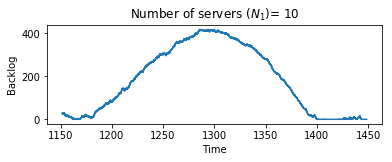

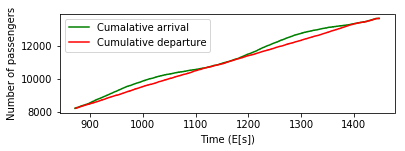

In [13]:
fig = plt.figure()
ax1 = plt.subplot(211)
plt.step(*zip(*job.b[-samplePathLen:, :2]), where='post')
plt.ylabel('Backlog')
plt.xlabel('Time')
plt.title('Number of servers ($N_{%s}$)= %s' % (1, N))
plt.show()

plt.subplot(212, sharex=ax1)
X = np.append(np.append(0, Ta), Td[-1])
Y = np.append(range(0, lengthTa + 1), lengthTa)
line_up, = plt.step(X[-samplePathLen:], Y[-samplePathLen:], 'g', where='post',
                    label='Cumalative arrival')
X = np.append(0, Td)
Y = range(0, lengthTa + 1)
line_down, = plt.step(X[-samplePathLen:], Y[-samplePathLen:], 'r', where='post', label='Cumulative departure')
plt.legend(handles=[line_up, line_down])
plt.ylabel('Number of passengers')
plt.xlabel('Time (E[s])')
plt.show()
if training:
    fig_path = directory + '/figs/Backlog_CumulativeArrDep %s_%s_%d (rho %3.2f).pdf' % (ArrivalType, ServiceType, N, rho)
    fig.savefig(fig_path, bbox_inches='tight')


# Preparing dataset for the learning problem

In [14]:
    # ///////////////////Data set for delay estimation//////////////
    begin = 0
    for k in np.arange(lengthTa):
        if jobMatrix[k, -1] != 0:
            begin = k
            break

    if TotHistLength > 0:
        delayHistory = jobMatrix[begin:, -TotHistLength:]
        delayHistory_Ta = jobMatrix[begin:, -2 * TotHistLength: -TotHistLength]
    occupancy = jobMatrix[:, 4].astype(int)
    occ = occupancy - N
    backlog = occ.clip(min=0)
    freeServers = -occ.clip(max=0)
    arrival = jobMatrix[:, 0]  # for plotting delay vs arrival times
    # departure= jobMatrix[:,1] #for plotting
    delay = jobMatrix[:, 3]
    MA = jobMatrix[:, 5]
    # Data Structure: 1-ServiceHistory(optional) 2-backlogUponArrival 3-#ofFreeServersUponArrival 4-ServiceTimeMovingAverage 5-SojournTime

    if training:
        # \\\\\\\\\\\\\\\\\\\train data \\\\\\\\\\\\\\\
        data = np.hstack((freeServers[begin:].reshape(-1, 1), MA[begin:].reshape(-1, 1)))  ## without queuelength information
        if TotHistLength > 0:
            data = np.hstack((data, delayHistory_Ta, delayHistory))

        data = np.hstack((arrival[begin:].reshape(-1, 1), data, delay[begin:].reshape(-1, 1)))
    else:
        # \\\\\\\\\\\\\\\\test data\\\\\\\\\\\\\\\
        data = np.array(list(zip(backlog[begin:], freeServers[begin:], MA[begin:])))
        if TotHistLength > 0:
            data = np.hstack((data, delayHistory_Ta, delayHistory))
        data = np.hstack((arrival[begin:].reshape(-1, 1), data, delay[begin:].reshape(-1, 1)))
        # 1)arrival 2)backlog 3)#ofFreeServers 4)serviceTimeMovingAverage 5)service hist 6)delay hist 7)label
        
    # ////////////////////////// eliminate all data with zero delay ////////////////////////////////////
    # ///////////(conditional delay given that the customer has to wait)////////////////////////////////
    data_all = data
    data = data_all[data_all[:, -1] > (10**-4)]
    # ///////////////////////////////Making Dataset more uniform//////////////////////

    sampled_data = np.zeros((1, data.shape[1]))
    nbins = 20
    if training:
        num_per_bin = int(train_length / nbins)
    # else:
    #     num_per_bin = int(test_length / nbins)
        bins = np.linspace(0, max(data[:, -1]), nbins+1)
        for i in range(1, nbins+1):
            temp = np.arange(data.shape[0])[np.digitize(data[:, -1], bins) == i]
            if len(temp) > 0.7 * num_per_bin:
                choose = np.random.choice(temp, min(num_per_bin, len(temp)), replace=False)
                sampled_data = np.append(sampled_data, data[choose, :], axis=0)
            else:
                break
        data = sampled_data[1:, :]
    # /////////////////////////////WRITING DATA////////////////////////////
    if save_flag:
        if training:
            with open(directory+'/dataset/DelayPredTrainingdata.csv', 'w') as csvFile:
                writer = csv.writer(csvFile)
                writer.writerows(data)
            csvFile.close()
        else:
            with open(directory+'/dataset/DelayPredTestdata.csv', 'w') as csvFile:
                writer = csv.writer(csvFile)
                writer.writerows(data)
            csvFile.close()
            with open(directory+'/dataset/samplePath.csv', 'w') as csvFile:
                writer = csv.writer(csvFile)
                writer.writerows(data_all[-samplePathLen:, :])
            csvFile.close()

# Plotting histogram and current deay vs LES delay

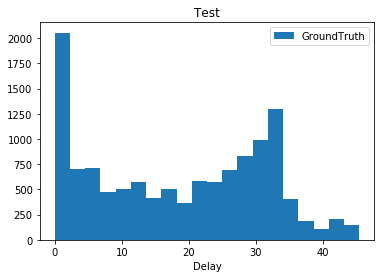

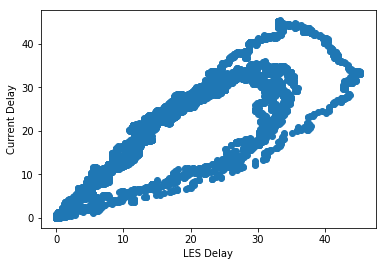

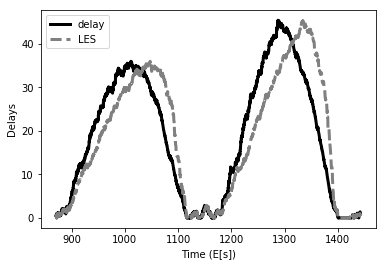

Average queue length in steady state: 158.021, Theoretical QL Mean: 15.686
Average # of customers in system (steady state): 167.503


In [15]:
fig = plt.figure()
plt.hist(data[:, -1], nbins, label=['GroundTruth'])
plt.xlabel('Delay')
plt.legend(loc='upper right')
if training:
    plt.title('Training')
else:
    plt.title('Test')
plt.show()
if training:
    fig_path = directory + '/figs/TrainDataHistogram %s_%s_%d (rho %3.2f).pdf' % (ArrivalType, ServiceType, N, rho)
    fig.savefig(fig_path, bbox_inches='tight')

fig = plt.figure()
plt.scatter(data[:, -2], data[:, -1])
plt.xlabel('LES Delay')
plt.ylabel('Current Delay')
plt.show()
if training:
    fig_path = directory + '/figs/delayVSles %s_%s_%d (rho %3.2f).pdf' % (ArrivalType, ServiceType, N, rho)
    fig.savefig(fig_path, bbox_inches='tight')

fig = plt.figure()
plt.plot(data_all[-samplePathLen:, 0], data_all[-samplePathLen:, -1], c='k', lw=3., label='delay')
plt.plot(data_all[-samplePathLen:, 0], data_all[-samplePathLen:, -2], c='0.5', lw=3., ls='--', label='LES')
plt.legend()
plt.xlabel('Time (E[s])')
plt.ylabel('Delays')
plt.show()
if training:
    fig_path = directory + '/figs/delay_lesVStime %s_%s_%d (rho %3.2f).pdf' % (ArrivalType, ServiceType, N, rho)
    fig.savefig(fig_path, bbox_inches='tight')

n_begin = 0
(n_end,) = np.where(job.b[:, 0] == Ta[-1])
n_end = int(n_end)
QL_sim = np.sum(np.diff(job.b[n_begin:n_end+1, 0])*job.b[n_begin:n_end, 1])/(job.b[n_end, 0]-job.b[n_begin, 0])
# QL_sim = np.sum(np.diff(job.b[n_begin:, 0])*job.b[n_begin:-1, 1])/(job.b[-1, 0]-job.b[n_begin, 0])
m = [np.math.factorial(n) for n in range(N)]
P0 = 1/(np.sum(((N*rho)**np.arange(N))/m) + ((N*rho)**N)/(np.math.factorial(N)*(1-rho)))
QL_th = (P0*rho*(N*rho)**N)/(np.math.factorial(N)*(1-rho)**2)
print('Average queue length in steady state: %5.3f, Theoretical QL Mean: %5.3f' %(QL_sim, QL_th))
B_bar = np.sum(np.diff(job.b[n_begin:n_end, 0])*job.b[n_begin:n_end-1, 2])/(job.b[n_end, 0]-job.b[n_begin, 0])
print('Average # of customers in system (steady state): %5.3f' %B_bar)
w_mean = np.mean(delay)